Import libraries

In [1]:
# 1. Install dependencies
!pip install mahotas scikit-learn opencv-python

# 2. Import modules
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import mahotas as mt
import glob
import os
import pandas as pd
import math
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
from scipy.special import kl_div

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = 'drive/MyDrive/2025/Doctorado/Artículo RS MDPI Visibility/20241215 Visibility Graphs/'

Mounted at /content/drive


Calculate ENL base

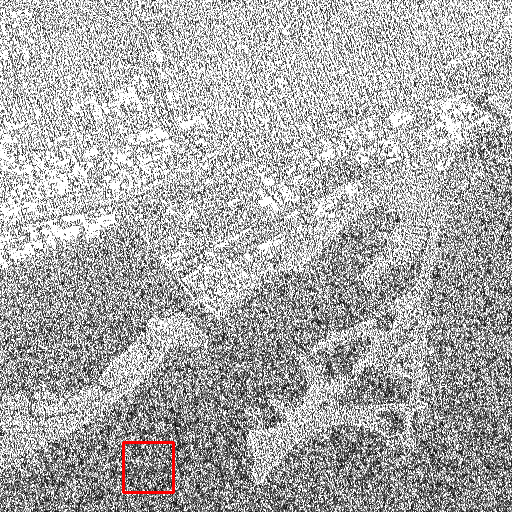

ENL:  2.954911680085494


True

In [2]:
base_image = '6400_1850'
x, y, size_rect = 123, 442, 50 #coordenada de anclaje

img_gamma = cv2.imread(path + 'Filt_AE80_Ratio/' + base_image + '.png', cv2.IMREAD_GRAYSCALE)
img_gamma_color = cv2.cvtColor(img_gamma, cv2.COLOR_GRAY2BGR)

cv2.rectangle(img_gamma_color, (x, y), (x+size_rect, y+size_rect), (0, 0, 255), 2)
cv2_imshow(img_gamma_color)
cv2.imwrite(path + 'Imgs_paper/' + 'roi.png', img_gamma_color)

enl = np.mean(img_gamma[y:y+size_rect, x:x+size_rect])**2 / np.std(img_gamma[y:y+size_rect, x:x+size_rect])**2
print('ENL: ', enl)

size = 512
shape = enl # k
scale = 1 / shape # θ
Gamma = np.random.gamma(shape=shape, scale=scale, size=(size, size)) # Generar matriz de ruido Gamma (50x50)
np.savetxt(path + '/Gamma/' + base_image + '.out', Gamma, delimiter=',')
Gamma = rescale_intensity(Gamma, out_range=(0, 255)).astype(np.uint8) # Reescalar intensidades al rango (0-255) para visualización, transformación lineal por entradas
cv2.imwrite(path + '/Gamma/' + base_image + '.png', Gamma)

Load ratio dataset

In [3]:
subfolders = ['Filt_AE80_Ratio', 'Filt_FANS2_Ratio', 'Filt_Monet_3_Ratio', 'Filt_Scunet_Ratio', 'Gamma']
subfolders_short =  ['AE', 'FANS', 'Monet', 'SCUNet', 'Gamma']

feature_list = []
img_list = []
img_out_list = []
filter = []

for subfolder in subfolders:
  print('Processing subfolder: ', subfolder)
  subfolder_path = os.path.join(path, subfolder)

  out_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]
  for out_file in out_files:
    print('Processing file: ', out_file)
    out_file_path = os.path.join(subfolder_path, out_file)
    #img = np.loadtxt(out_file_path, delimiter=',')
    img = cv2.imread(out_file_path, cv2.IMREAD_GRAYSCALE)
    img_list.append(img)
    img_out = np.loadtxt(out_file_path.replace('.png', '.out'), delimiter=',')
    img_out_list.append(img_out)
    features = mt.features.haralick((100*img).astype(np.uint16), ignore_zeros=True,
                                                 compute_14th_feature=True,
                                                 use_x_minus_y_variance=True,
                                                 distance=9).mean(axis=0)
    feature_list.append(features)
    filter.append(subfolder)

filter_short = filter.copy()
filter_short = np.where(filter_short == 'Filt_AE80_Ratio', 'AE', filter_short)
filter_short = np.where(filter_short == 'Filt_AE80_Ratio', 'AE', filter_short)
filter_short = np.where(filter_short == 'Filt_FANS2_Ratio', 'FANS', filter_short)
filter_short = np.where(filter_short == 'Filt_Monet_3_Ratio', 'Monet', filter_short)
filter_short = np.where(filter_short == 'Filt_Scunet_Ratio', 'SCUNet', filter_short)
print(filter_short)

Processing subfolder:  Filt_AE80_Ratio
Processing file:  2030_2895.png
Processing file:  4100_1500.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Filt_FANS2_Ratio
Processing file:  2030_2895.png
Processing file:  4100_1500.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Filt_Monet_3_Ratio
Processing file:  2030_2895.png
Processing file:  4100_1500.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Filt_Scunet_Ratio
Processing file:  4100_1500.png
Processing file:  2030_2895.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Gamma
Processing file:  6400_1850.png
['AE' 'AE' 'AE' 'AE' 'AE' 'FANS' 'FANS' 'FANS' 'FANS' 'FANS' 'Monet'
 'Monet' 'Monet' 'Monet' 'Monet' 'SCUNet' 'SCUNet' 'SCUNet' 'SCUNet'
 'SCUNe

Plot al Haralick features

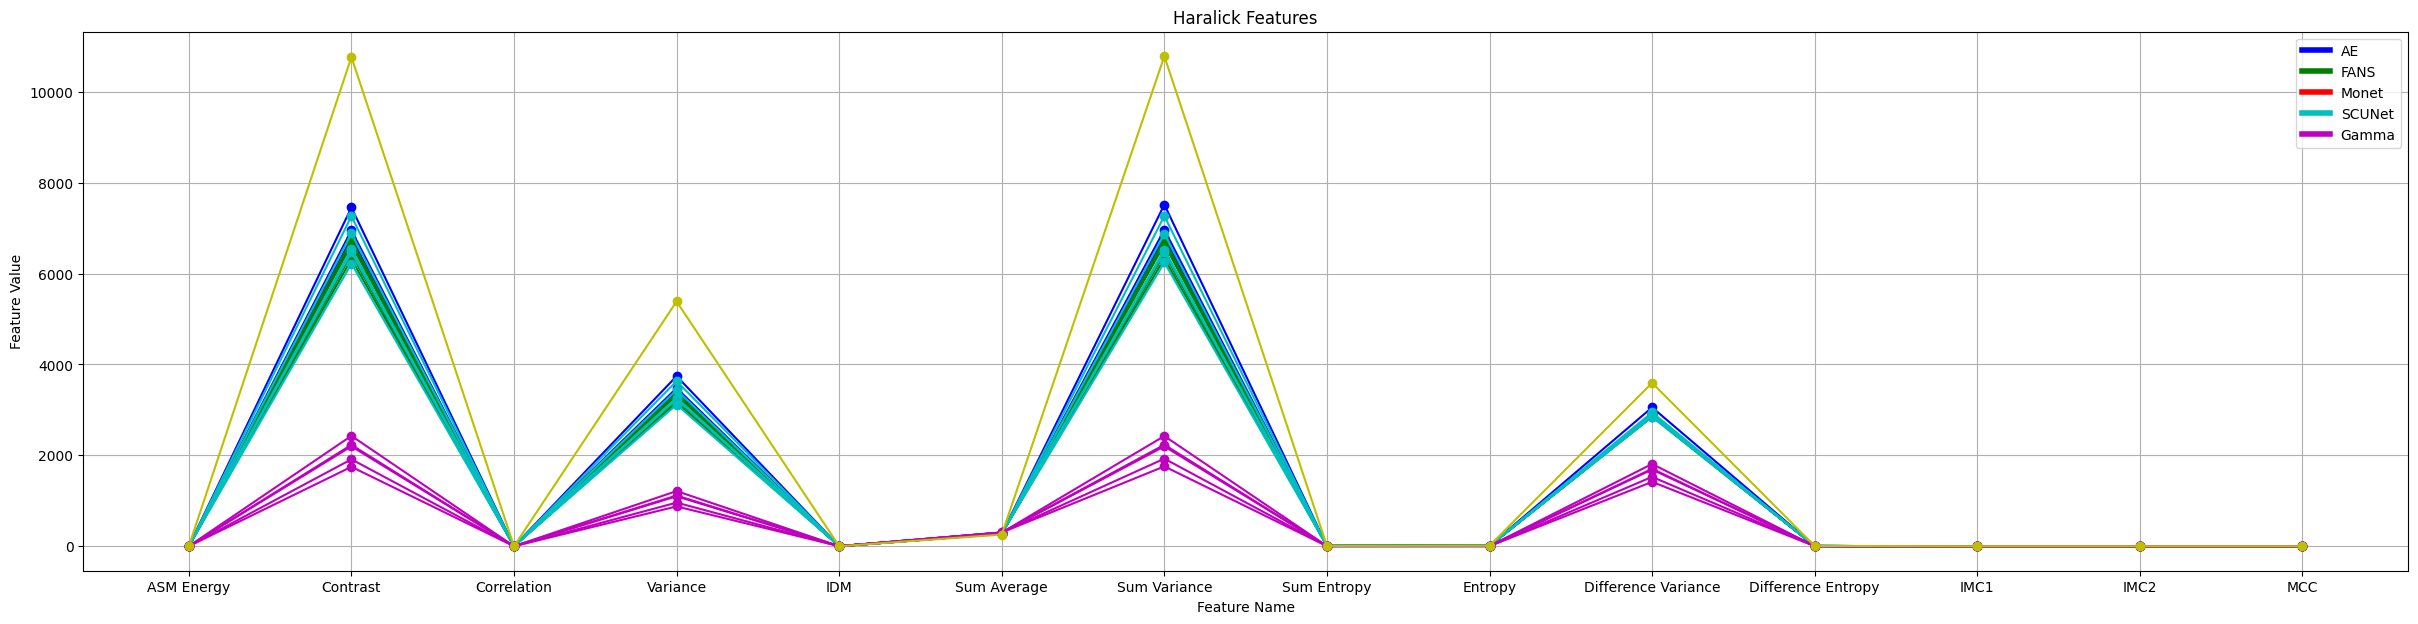

In [4]:
t = np.arange(0, len(feature_list[0]))

plt.figure(figsize=(30, 7))
markers = ['o', 's', '^', 'x', '+', 'v', '*', 'D', 'P', 'H'] # Example markers

for i, features in enumerate(feature_list):
    marker = markers[i % len(markers)] # Cycle through markers
    if filter_short[i] == 'AE':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='b')
    elif filter_short[i] == 'FANS':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='g')
    elif filter_short[i] == 'Monet':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='c')
    elif filter_short[i] == 'SCUNet':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='m')
    elif filter_short[i] == 'Gamma':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='y')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')
plt.title('Haralick Features')

categories = ['ASM Energy', 'Contrast', 'Correlation', 'Variance', 'IDM', 'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy',
              'Difference Variance', 'Difference Entropy', 'IMC1', 'IMC2', 'MCC']
x_positions = np.arange(len(categories))
plt.xticks(x_positions, categories)

custom_lines = [plt.Line2D([0], [0], color='b', lw=4),
                plt.Line2D([0], [0], color='g', lw=4),
                plt.Line2D([0], [0], color='r', lw=4),
                plt.Line2D([0], [0], color='c', lw=4),
                plt.Line2D([0], [0], color='m', lw=4),
                plt.Line2D([0], [0], color='y', lw=4)]
plt.legend(custom_lines, ['AE', 'FANS', 'Monet', 'SCUNet', 'Gamma'])
plt.grid(True)
plt.savefig(path + 'Imgs_paper/' + 'Haralick_all.pdf', bbox_inches='tight', pad_inches=0)
#plt.show()

Correlation matrix

In [5]:
feature_all_pd = pd.DataFrame(feature_list)
#feature_all_pd['Filter'] = filter_short
feature_all_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.039619,6442.790549,0.001070,3224.845267,0.201838,279.890674,6456.590520,5.859466,8.667356,2870.734353,5.104475,-0.001304,0.106031,0.053090
1,0.032441,6704.605833,0.002120,3359.424373,0.182992,278.174188,6733.091660,5.959455,8.938939,2911.159685,5.180576,-0.001329,0.108692,0.054222
2,0.018587,7454.127389,0.004197,3742.776367,0.140993,274.202941,7516.978081,6.186373,9.732305,3054.765987,5.350426,-0.002109,0.142589,0.073941
3,0.028199,6785.817722,0.001554,3398.187576,0.170588,277.747155,6806.932583,6.011639,9.054649,2892.113347,5.219796,-0.001238,0.105615,0.055742
4,0.025057,6950.575377,0.001018,3478.829222,0.161054,276.971543,6964.741512,6.060039,9.186653,2917.317351,5.257277,-0.001240,0.106458,0.057092


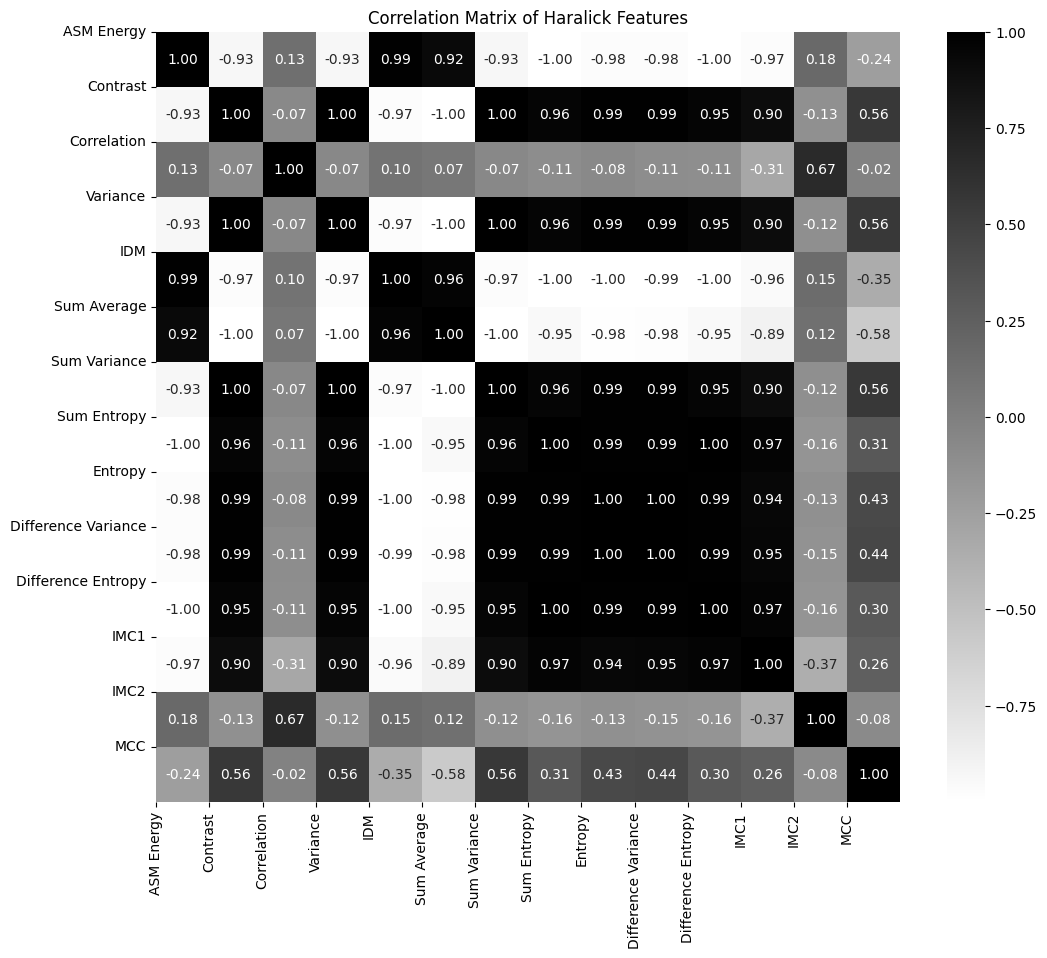

In [6]:
plt.figure(figsize=(12, 10))
h = sns.heatmap(feature_all_pd.corr(), annot=True, cmap='binary', fmt=".2f")

categories = ['ASM Energy', 'Contrast', 'Correlation', 'Variance', 'IDM', 'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy',
              'Difference Variance', 'Difference Entropy', 'IMC1', 'IMC2', 'MCC']
x_positions = np.arange(len(categories))

plt.yticks(x_positions, categories, rotation=0)
plt.xticks(x_positions, categories, rotation=90)

plt.title('Correlation Matrix of Haralick Features')
plt.savefig(path + 'Imgs_paper/' + 'Corr.pdf', bbox_inches='tight', pad_inches=0)

Delete descriptors (except 1-contrast and 3-divergence)

In [7]:
feature_list_short = feature_list.copy()
for i in range(len(feature_list_short)):
  new = np.delete(feature_list_short[i], [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
  feature_list_short[i] = new

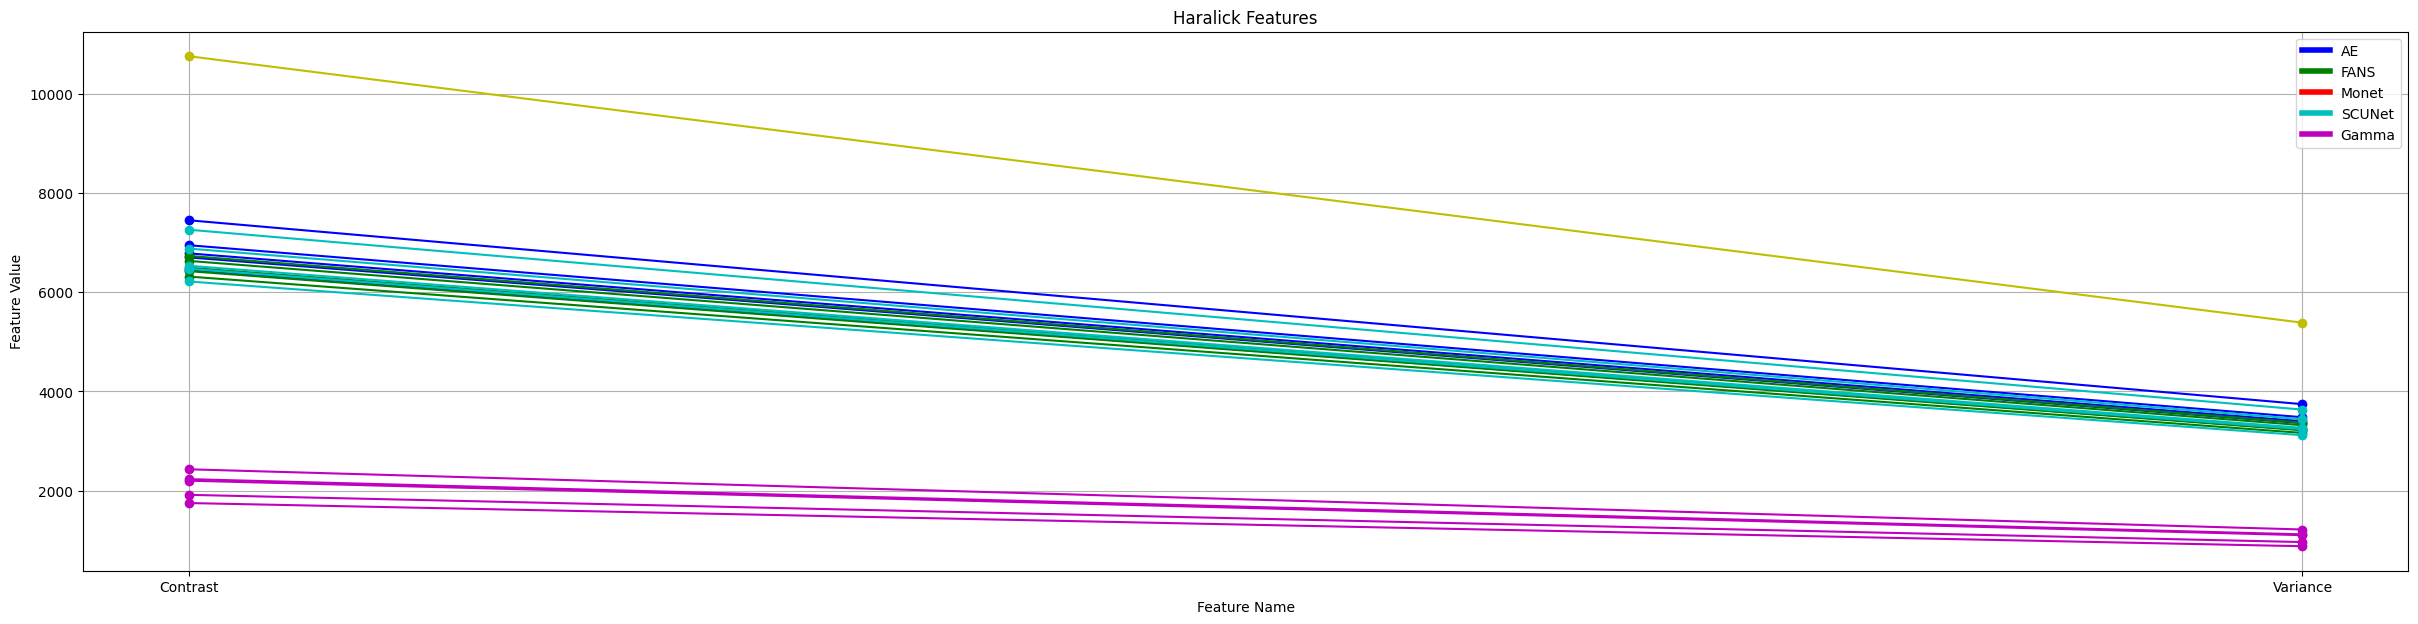

In [8]:
edgecolor='red'
t = np.arange(0, len(feature_list_short[0]))

plt.figure(figsize=(30, 7))

for i, features in enumerate(feature_list_short):
    #marker = markers[i % len(markers)] # Cycle through markers
    if filter_short[i] == 'AE':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='b')
    elif filter_short[i] == 'FANS':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='g')
    elif filter_short[i] == 'Monet':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='c')
    elif filter_short[i] == 'SCUNet':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='m')
    elif filter_short[i] == 'Gamma':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='y')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')
plt.title('Haralick Features')

categories = ['Contrast', 'Variance']
x_positions = np.arange(len(categories))
plt.xticks(x_positions, categories)

custom_lines = [plt.Line2D([0], [0], color='b', lw=4),
                plt.Line2D([0], [0], color='g', lw=4),
                plt.Line2D([0], [0], color='r', lw=4),
                plt.Line2D([0], [0], color='c', lw=4),
                plt.Line2D([0], [0], color='m', lw=4),
                plt.Line2D([0], [0], color='y', lw=4)]
plt.legend(custom_lines, ['AE', 'FANS', 'Monet', 'SCUNet', 'Gamma'])
plt.grid(True)
plt.savefig(path + 'Imgs_paper/' + 'Haralick_2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [9]:
feature_pd = pd.DataFrame(feature_list_short)
feature_pd['Filter'] = filter_short
feature_pd.head()

,0,1,Filter
0,6442.790549,3224.845267,AE
1,6704.605833,3359.424373,AE
2,7454.127389,3742.776367,AE
3,6785.817722,3398.187576,AE
4,6950.575377,3478.829222,AE


/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)


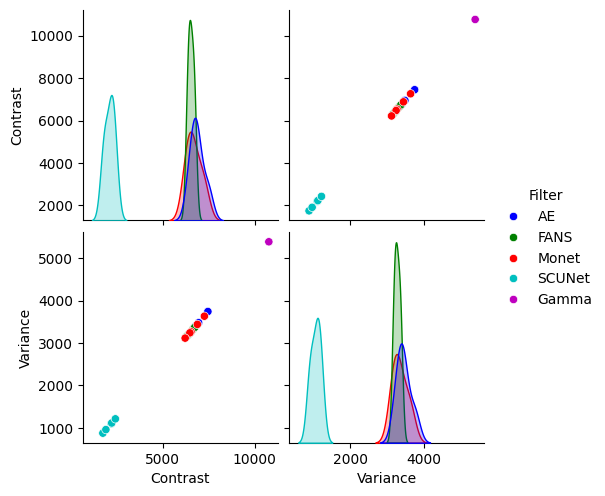

In [10]:
# Create the pairplot
custom_colors = ["b", "g", "r", 'c', 'm', 'y']
g = sns.pairplot(feature_pd, hue='Filter', palette=custom_colors)

# Get the axes from the pairplot
axes = g.axes

# Set the labels for the axes
axes[0, 0].set_xlabel("Contrast")
axes[0, 0].set_ylabel("Contrast")
axes[0, 1].set_xlabel("Variance")
axes[0, 1].set_ylabel("Contrast")
axes[1, 0].set_xlabel("Contrast")
axes[1, 0].set_ylabel("Variance")
axes[1, 1].set_xlabel("Variance")
axes[1, 1].set_ylabel("Variance")

plt.savefig(path + 'Imgs_paper/' + 'pairplot.pdf')

Gamma analysis

In [11]:
subfolders = ['Filt_AE80_Ratio', 'Filt_FANS2_Ratio', 'Filt_Monet_3_Ratio', 'Filt_Scunet_Ratio', 'Gamma']
size_rect = 30

roi_list = []
gamma_vals = []

for subfolder in subfolders:
  print('Processing subfolder: ', subfolder)
  subfolder_path = os.path.join(path, subfolder)

  out_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]
  for out_file in out_files:
    print('Processing file: ', out_file)
    out_file_path = os.path.join(subfolder_path, out_file)
    img = cv2.imread(out_file_path, cv2.IMREAD_GRAYSCALE)

    if out_file == '2030_2895.png':
      x, y = 292, 468
    elif out_file == '4100_1500.png':
      x, y = 147, 189
    elif out_file == '6400_1850.png':
      x, y = 123, 442 #coordenada de anclaje
    elif out_file == '7200_500.png':
      x, y = 444, 11
    elif out_file == '7750_280.png':
      x, y = 349, 114
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_color, (x, y), (x+size_rect, y+size_rect), (0, 0, 255), 2)
    new_path = out_file_path.replace(subfolder, subfolder + '_roi')
    cv2.imwrite(new_path, img_color)

    ratio = np.loadtxt(out_file_path.replace('png', 'out'), delimiter=',')
    roi = ratio[y:y+size_rect, x:x+size_rect]
    roi_list.append(roi)
    shape, loc, scale = gamma.fit(roi.flatten(), floc=0)
    gamma_vals.append([shape, loc, scale])



Processing subfolder:  Filt_AE80_Ratio
Processing file:  2030_2895.png
Processing file:  4100_1500.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Filt_FANS2_Ratio
Processing file:  2030_2895.png
Processing file:  4100_1500.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Filt_Monet_3_Ratio
Processing file:  2030_2895.png
Processing file:  4100_1500.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Filt_Scunet_Ratio
Processing file:  4100_1500.png
Processing file:  2030_2895.png
Processing file:  6400_1850.png
Processing file:  7200_500.png
Processing file:  7750_280.png
Processing subfolder:  Gamma
Processing file:  6400_1850.png


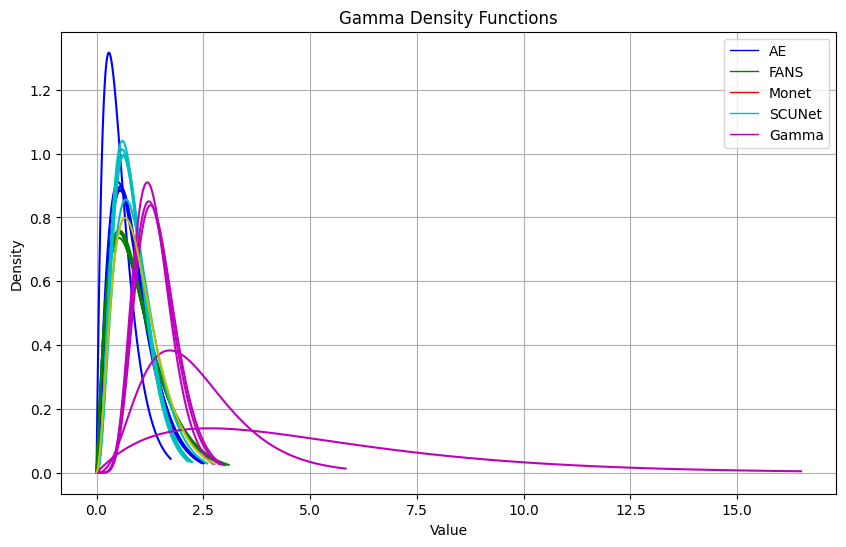

In [12]:
plt.figure(figsize=(10, 6))

for i, (shape, loc, scale) in enumerate(gamma_vals):
    # Generate points for the gamma distribution
    # Determine appropriate x limits based on the fitted parameters
    mean = shape * scale
    std_dev = np.sqrt(shape * scale**2)
    # Generate x values from a reasonable range, e.g., mean +/- 3 standard deviations
    xmin = max(0, mean - 3 * std_dev) # Ensure xmin is not negative
    xmax = mean + 3 * std_dev
    x_values = np.linspace(xmin, xmax, 100)
    pdf = gamma.pdf(x_values, shape, loc, scale)
    if filter_short[i] == 'AE':
        plt.plot(x_values, pdf, label=f'Feature Set {i+1}', color='b')
    elif filter_short[i] == 'FANS':
        plt.plot(x_values, pdf, label=f'Feature Set {i+1}', color='g')
    elif filter_short[i] == 'Monet':
        plt.plot(x_values, pdf, label=f'Feature Set {i+1}', color='c')
    elif filter_short[i] == 'SCUNet':
        plt.plot(x_values, pdf, label=f'Feature Set {i+1}', color='m')
    elif filter_short[i] == 'Gamma':
        plt.plot(x_values, pdf, label=f'Feature Set {i+1}', color='y')

custom_lines = [plt.Line2D([0], [0], color='b', lw=1),
                plt.Line2D([0], [0], color='g', lw=1),
                plt.Line2D([0], [0], color='r', lw=1),
                plt.Line2D([0], [0], color='c', lw=1),
                plt.Line2D([0], [0], color='m', lw=1),
                plt.Line2D([0], [0], color='y', lw=1)]
plt.legend(custom_lines, ['AE', 'FANS', 'Monet', 'SCUNet', 'Gamma'])

    #plt.plot(x_values, pdf, label=filter_short[i])

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Gamma Density Functions')
#plt.legend()
plt.grid(True)
plt.savefig(path + 'Imgs_paper/' + 'gammapdf.pdf', bbox_inches='tight', pad_inches=0)
#plt.show()

In [13]:
def jensen_shannon_divergence(p, q, x):
    """Calculates the Jensen-Shannon divergence between two probability distributions p and q."""
    m = 0.5 * (p + q)
    jsd = 0.5 * np.sum(kl_div(p, m)) + 0.5 * np.sum(kl_div(q, m))
    return jsd

# Get the parameters for the reference gamma distribution
shape_ref, loc_ref, scale_ref = gamma_vals[20]

# Define a range of x values for evaluation
# Use a wider range that covers the support of all distributions
# Determine appropriate x limits based on the fitted parameters of all distributions
all_shapes = [params[0] for params in gamma_vals]
all_scales = [params[2] for params in gamma_vals]
max_mean = max(s * sc for s, sc in zip(all_shapes, all_scales))
max_std_dev = max(np.sqrt(s * sc**2) for s, sc in zip(all_shapes, all_scales))
xmin = max(0, max_mean - 4 * max_std_dev) # Ensure xmin is not negative and covers a wider range
xmax = max_mean + 4 * max_std_dev
x_values = np.linspace(xmin, xmax, 1000) # Use more points for better approximation

# Calculate the PDF for the reference distribution
pdf_ref = gamma.pdf(x_values, shape_ref, loc_ref, scale_ref)

# Calculate JSD for the first 5 distributions with respect to the reference
jsd_values = []
for i in range(21):
    shape, loc, scale = gamma_vals[i]
    pdf = gamma.pdf(x_values, shape, loc, scale)
    jsd = jensen_shannon_divergence(pdf, pdf_ref, x_values)
    jsd_values.append(jsd)
    print(f"JSD between {filter_short[i]} and {filter_short[20]}: {jsd:.4f}")

JSD between AE and Gamma: 0.3539
JSD between AE and Gamma: 0.6390
JSD between AE and Gamma: 5.1731
JSD between AE and Gamma: 0.3523
JSD between AE and Gamma: 0.3276
JSD between FANS and Gamma: 0.3115
JSD between FANS and Gamma: 0.3945
JSD between FANS and Gamma: 0.3871
JSD between FANS and Gamma: 0.3809
JSD between FANS and Gamma: 0.2604
JSD between Monet and Gamma: 0.7318
JSD between Monet and Gamma: 0.5837
JSD between Monet and Gamma: 0.0668
JSD between Monet and Gamma: 0.6166
JSD between Monet and Gamma: 0.8744
JSD between SCUNet and Gamma: 11.1747
JSD between SCUNet and Gamma: 5.7207
JSD between SCUNet and Gamma: 19.6558
JSD between SCUNet and Gamma: 4.8972
JSD between SCUNet and Gamma: 5.1033
JSD between Gamma and Gamma: 0.0000


In [14]:
features_complete_pd = feature_pd.copy()
features_complete_pd['jsd'] = jsd_values
cols = list(features_complete_pd.columns)
idx1 = cols.index('Filter')
idx2 = cols.index('jsd')
cols[idx1], cols[idx2] = cols[idx2], cols[idx1]
df_swapped = features_complete_pd[cols]
print(df_swapped.head())

             0            1       jsd Filter
0  6442.790549  3224.845267  0.353884     AE
1  6704.605833  3359.424373  0.639048     AE
2  7454.127389  3742.776367  5.173057     AE
3  6785.817722  3398.187576  0.352260     AE
4  6950.575377  3478.829222  0.327563     AE


In [15]:
df_swapped.columns = df_swapped.columns.astype(str)
df_swapped.head()

,0,1,jsd,Filter
0,6442.790549,3224.845267,0.353884,AE
1,6704.605833,3359.424373,0.639048,AE
2,7454.127389,3742.776367,5.173057,AE
3,6785.817722,3398.187576,0.352260,AE
4,6950.575377,3478.829222,0.327563,AE


Multiply IVG * ratio (not used)

In [16]:
path_new = 'drive/MyDrive/2025/Doctorado/Artículo RS MDPI Visibility/20241215 Visibility Graphs/IHVG K5/'
subfolders = ['IHVG_AE80_Ratio', 'IHVG_FANS2_Ratio', 'IHVG_Monet_3_Ratio', 'IHVG_Scunet_Ratio']

ivg_list = []

for subfolder in subfolders:
  print('Processing subfolder: ', subfolder)
  subfolder_path = os.path.join(path_new, subfolder)

  out_files = [f for f in os.listdir(subfolder_path) if f.endswith('.out')]
  for out_file in out_files:
    print('Processing file: ', out_file)
    out_file_path = os.path.join(subfolder_path, out_file)
    img_out = np.loadtxt(out_file_path, delimiter=',')
    ivg_list.append(img_out)

Processing subfolder:  IHVG_AE80_Ratio
Processing file:  4100_1500.out
Processing file:  6400_1850.out
Processing file:  7200_500.out
Processing file:  7750_280.out
Processing file:  2030_2895.out
Processing subfolder:  IHVG_FANS2_Ratio
Processing file:  4100_1500.out
Processing file:  6400_1850.out
Processing file:  7200_500.out
Processing file:  7750_280.out
Processing file:  2030_2895.out
Processing subfolder:  IHVG_Monet_3_Ratio
Processing file:  2030_2895.out
Processing file:  4100_1500.out
Processing file:  6400_1850.out
Processing file:  7200_500.out
Processing file:  7750_280.out
Processing subfolder:  IHVG_Scunet_Ratio
Processing file:  2030_2895.out
Processing file:  4100_1500.out
Processing file:  6400_1850.out
Processing file:  7200_500.out
Processing file:  7750_280.out


In [17]:
mult_list = np.multiply(img_out_list[0:20], ivg_list)

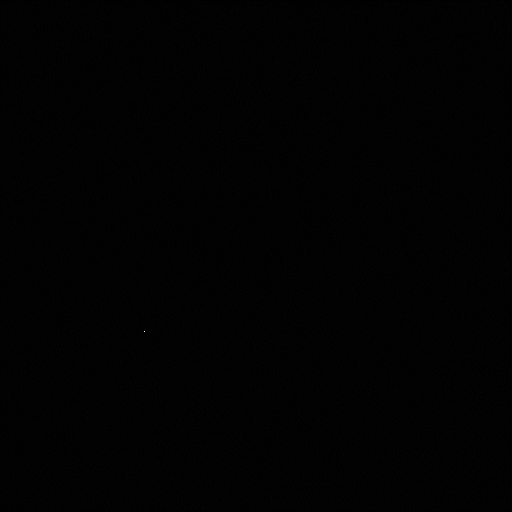

In [18]:
img_show = rescale_intensity(mult_list[12], out_range=(0, 255)).astype(np.uint8)
cv2_imshow(img_show)

In [19]:
ivg_feature_list = []

for img in mult_list:
  features = mt.features.haralick(img_out.astype(np.uint16), ignore_zeros=True,
                                                 compute_14th_feature=True,
                                                 use_x_minus_y_variance=True,
                                                 distance=9).mean(axis=0)
  ivg_feature_list.append(features)

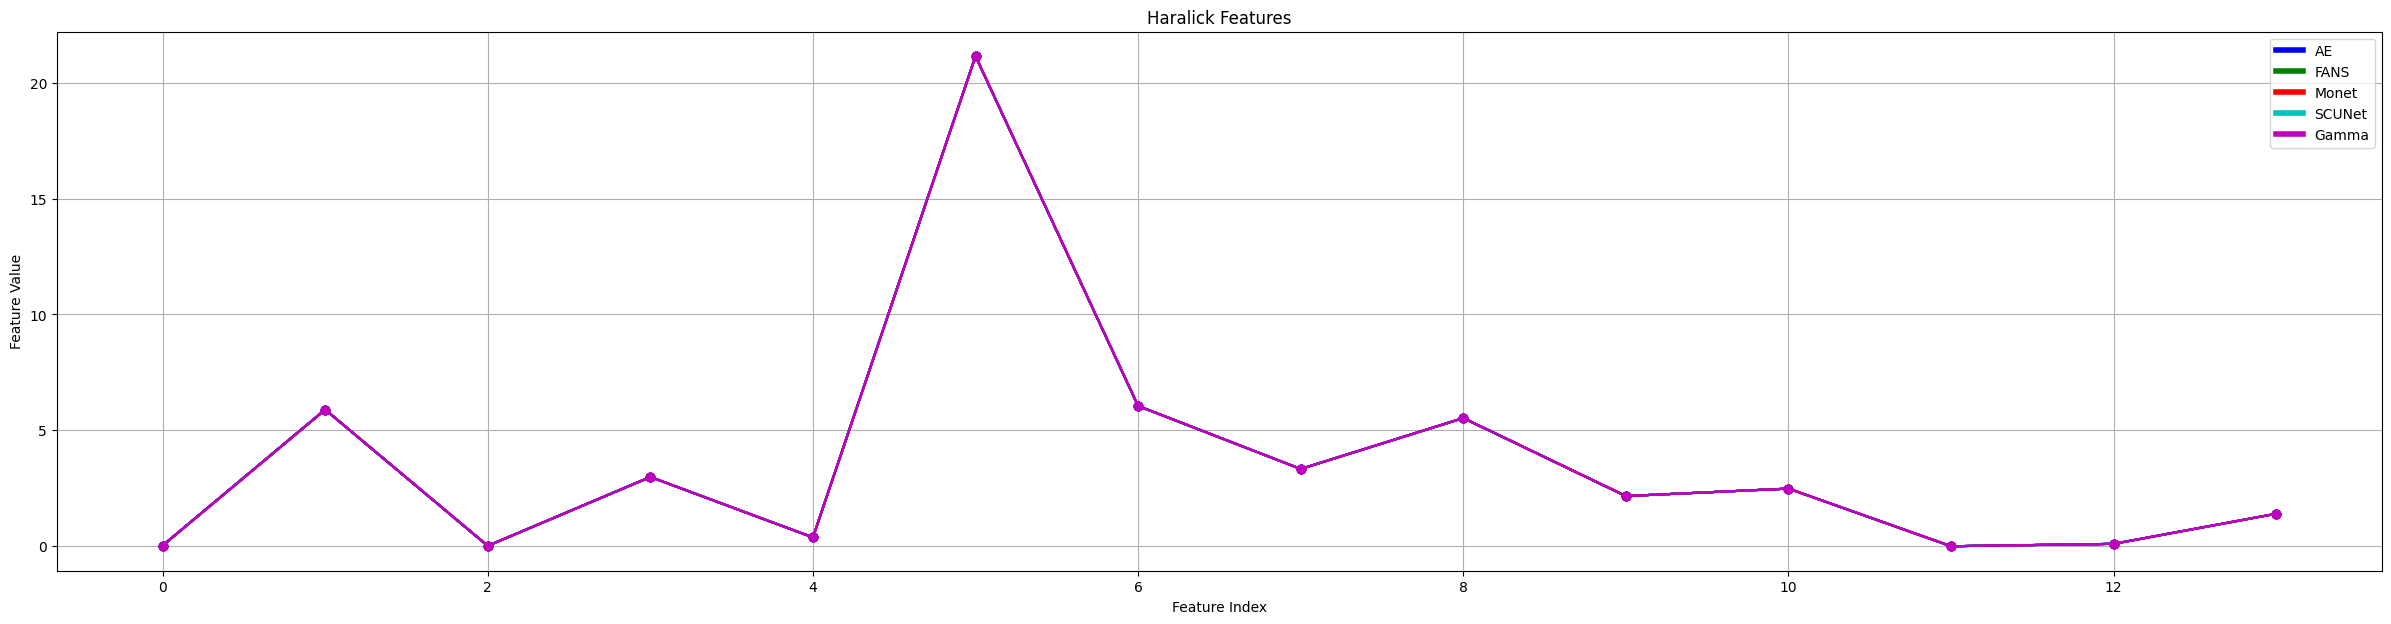

In [20]:
t = np.arange(0, len(ivg_feature_list[0]))

plt.figure(figsize=(30, 7))
markers = ['o', 's', '^', 'x', '+', 'v', '*', 'D', 'P', 'H'] # Example markers

for i, features in enumerate(ivg_feature_list):
    marker = markers[i % len(markers)] # Cycle through markers
    if filter_short[i] == 'AE':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='b')
    elif filter_short[i] == 'FANS':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='g')
    elif filter_short[i] == 'Monet':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='c')
    elif filter_short[i] == 'SCUNet':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='m')
    elif filter_short[i] == 'Gamma':
        plt.plot(t, features, marker='o', label=f'Feature Set {i+1}', color='y')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Haralick Features')

custom_lines = [plt.Line2D([0], [0], color='b', lw=4),
                plt.Line2D([0], [0], color='g', lw=4),
                plt.Line2D([0], [0], color='r', lw=4),
                plt.Line2D([0], [0], color='c', lw=4),
                plt.Line2D([0], [0], color='m', lw=4),
                plt.Line2D([0], [0], color='y', lw=4)]
plt.legend(custom_lines, ['AE', 'FANS', 'Monet', 'SCUNet', 'Gamma'])

plt.grid(True)
#plt.savefig(path + 'Imgs_paper/' + 'Haralick_all.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#Texture-Divergence Measurement

In [21]:
df_calc = df_swapped.copy()
df_calc.rename(columns={'0': 'Contrast'}, inplace=True)
df_calc.rename(columns={'1': 'Variance'}, inplace=True)
df_calc.head()

,Contrast,Variance,jsd,Filter
0,6442.790549,3224.845267,0.353884,AE
1,6704.605833,3359.424373,0.639048,AE
2,7454.127389,3742.776367,5.173057,AE
3,6785.817722,3398.187576,0.352260,AE
4,6950.575377,3478.829222,0.327563,AE


Divide by maximum value of images (in this case 255)

In [22]:
df_overmax = df_calc.copy()

df_overmax['Contrast'] = df_overmax['Contrast'] / 255
df_overmax['Variance'] = df_overmax['Variance'] / 255
df_overmax.head()

,Contrast,Variance,jsd,Filter
0,25.265845,12.646452,0.353884,AE
1,26.292572,13.174213,0.639048,AE
2,29.231872,14.677554,5.173057,AE
3,26.611050,13.326226,0.352260,AE
4,27.257158,13.642468,0.327563,AE


Apply sigmoid function

In [23]:
df_sigmoid = df_overmax.copy()

#Sigmoid function for Contrast measurement with mu=(last element of Contrast colum)/4 and shape=5
mu = df_sigmoid["Contrast"].iloc[-1]
print('Contrast - Mu from gamma reference image: ', mu)
shape = 5
df_sigmoid['Contrast'] = 1 / (1 + np.exp(-(df_sigmoid["Contrast"] - (mu / 4)) / shape))

#Sigmoid function for Variance measurement with mu=(last element of Variance colum)/4 and shape=5
mu = df_sigmoid["Variance"].iloc[-1]
print('Variance - Mu from gamma reference image: ', mu)
shape = 5
df_sigmoid['Variance'] = 1 / (1 + np.exp(-(df_sigmoid["Variance"] - (mu / 4)) / shape))

#Sigmoid function for JSD measurement with mu=(last element of JSD colum)/4 and shape=1

mu = df_sigmoid["jsd"].iloc[-1]
print('JSD - Mu from gamma reference image: ', mu)
shape = 1
df_sigmoid['jsd'] = 1 / (1 + np.exp(-(df_sigmoid["jsd"] - (mu / 4)) / shape))
#Result = (Result - 0.5) * 2
df_sigmoid['jsd'] = (df_sigmoid['jsd'] - 0.5) * 2
df_sigmoid.head()

Contrast - Mu from gamma reference image:  42.21358033162326
Variance - Mu from gamma reference image:  21.12439666097393
JSD - Mu from gamma reference image:  0.0


,Contrast,Variance,jsd,Filter
0,0.949907,0.813524,0.175118,AE
1,0.958823,0.829009,0.309076,AE
2,0.976699,0.867530,0.988729,AE
3,0.961266,0.833276,0.174331,AE
4,0.965801,0.841879,0.162333,AE


TDM final calculation

In [25]:
#Create the new 'Metric' column

df_tdm = df_sigmoid.copy()

wc, wv, wd = 0.25, 0.25, 0.5
df_tdm['Metric'] = wc *  df_tdm['Contrast'] + wv * df_tdm['Variance'] + wd * (1 - df_tdm['jsd'])
df_tdm['Metric'] = df_tdm['Metric'] / (wc + wv + wd)
df_tdm.head()
df_tdm.to_csv(path + 'Imgs_paper/' + 'tdm_final.csv')